# Logistic Regression

I apply Logistic regression to the Titanic dataset (from Kaggle) to predict survivors on the Titanic using passenger details as features.

In [1]:
#import data handling and graphing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sb

#import Scikit-learn libraries
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

## Exploration

In [2]:
data = pd.read_csv('data.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.shape

(891, 12)

In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


On average, only 38% of passengers on the Titanic survived. The Survived column is the outcome (Y) variable I are interested in.

In [5]:
#check missing values
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Pre-processing

I drop the features that are unlikely to have predictive power (including Name, PassengerId and Ticket). Cabin has many missing values and it is unlikely to have much predictive power after adjusting for Pclass and Fare. So, I drop it too.

In [6]:
data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [7]:
#drop missing values in 'Embarked'
data['Embarked'] = data['Embarked'].dropna()

Now, I convert non-numeric features into numeric variables by creating dummies. For this, I check which variables are object types. Pclass is coded as numbers but it is a categorical variable  - i.e. the difference between 1 and 2 cannot be assumed to be the same as that between 2 and 3. So, I convert Pclass into a string to then convert it into a dummy.

In [8]:
data['Pclass'] = data['Pclass'].astype(str)
data.dtypes

Survived      int64
Pclass       object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [9]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1


In [10]:
#check no object type remaining
data.dtypes

Survived        int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Pclass_2        uint8
Pclass_3        uint8
Sex_male        uint8
Embarked_Q      uint8
Embarked_S      uint8
dtype: object

In [11]:
#final check for msising values
data.isnull().sum()

Survived        0
Age           177
SibSp           0
Parch           0
Fare            0
Pclass_2        0
Pclass_3        0
Sex_male        0
Embarked_Q      0
Embarked_S      0
dtype: int64

Age is the only variable that still has missing values. To tackle this, I make two models: one where I drop the obsevrations where Age is missing, the second where I impute missing values for Age.

## Model 1: missing values dropped

In [12]:
X = data.dropna()
X.isnull().sum()

Survived      0
Age           0
SibSp         0
Parch         0
Fare          0
Pclass_2      0
Pclass_3      0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [13]:
X.shape

(714, 10)

I separate the data into two dataframnes (X and Y). X only has the features and Y only has the outcome (Survived).

In [14]:
Y = X['Survived']
X.pop('Survived')
X.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
#split data into training and test sub-datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .25, random_state=25)

In [16]:
#size of training dataset: 535 observations
X_train.shape

(535, 9)

In [17]:
#size of test dataset: 179 observations
X_test.shape

(179, 9)

In [18]:
Y_train.shape

(535,)

In [19]:
Y_test.shape

(179,)

In [20]:
#speficy model type
logit = LogisticRegression()

In [21]:
logit.fit(X_train, Y_train)

C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Model 1: performance metrics

In [22]:
Y_pred = logit.predict(X_test)
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[86 17]
 [21 55]]


Note: due to the labelling of the outcome variable (0 = dead, 1 = survived), it is easier to interpret the confusion matrix this way:

                        Dead(0)    Alive(1)
    predicted dead        TN         FN

    predicted alive       FP         TP  


TP = correctly predicted survivor

TN = correctly predicted dead

FP = dead but incorrectly predicted as survivor

FN = survived but incorrectly predicted as dead

## Please raise an issue if this interpretation seems inaccurate

In [23]:
print(metrics.accuracy_score(Y_test, Y_pred))

0.7877094972067039


In [24]:
#accuracy score manual check: (TP + TN) / total
(55+86)/(86+17+21+55)

0.7877094972067039

In [25]:
print(metrics.classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       103
           1       0.76      0.72      0.74        76

   micro avg       0.79      0.79      0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



## Interpretation

The first model is approx. 79% accurate - i.e. 79% of predictions are correct.

Precision: Of all the passengers labelled by the model as dead, 80% actually died. Of all the passengers labelled by the model as survivors, 76% actually survived.

Recall: Of all the passengers that truly died, the model correctly labelled 83% of them. Of all the passengers that truly survived, the model correctly labelled 72% of them. 

Now, I plot the ROC curve. For this, I need the predicted probabilities in the test sample.

In [26]:
prob = logit.predict_proba(X_test)

In [27]:
pred = prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, pred)

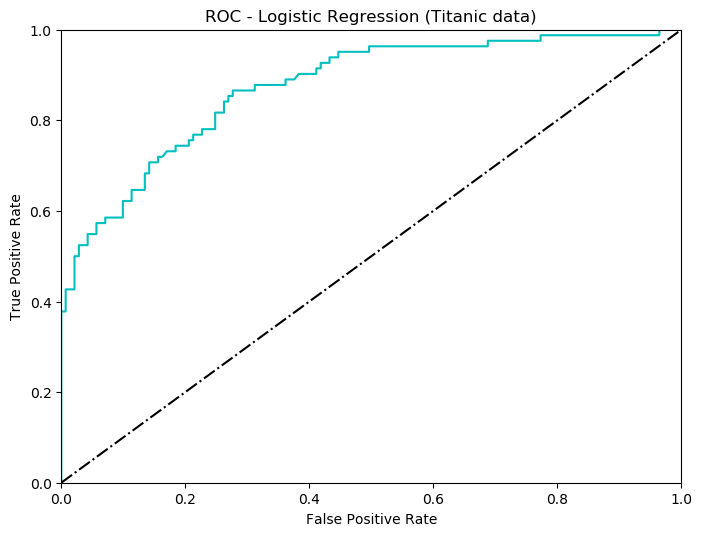

In [44]:
plt.title('ROC - Logistic Regression (Titanic data)')
plt.plot(fpr, tpr, 'c')
plt.plot([0, 1], [0, 1],'k-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

In [29]:
metrics.roc_auc_score(Y_test, pred)

0.8649718957588146

The area under the curve is 86%, which means there is an 86% chance that the model will be able to distinguish between the two classes (survivors and deads).

## Model 2: missing values imputed

A simple imputation strategy would be to use the mean value of Age (mean of the non-missing values). Based on descriptive statistics above, mean age = 29.70, which is pretty close to median = 28. The data is skewed to the left; there are few old people. So, using the mean for imputation seems appropriate.

In [30]:
data2 = data
imp = SimpleImputer(strategy='mean')
data2 = imp.fit_transform(data2)
#transform np array into pd df
data2 = pd.DataFrame.from_records(data2, columns=['Survived','Age','SibSp','Parch','Fare','Pclass_2','Pclass_3','Sex_male','Embarked_Q', 'Embarked_S'])
data2.isnull().sum()

Survived      0
Age           0
SibSp         0
Parch         0
Fare          0
Pclass_2      0
Pclass_3      0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [31]:
X = data2
Y = X['Survived']
X.pop('Survived')
X.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .25, random_state=25)

In [33]:
X_train.shape

(668, 9)

In [34]:
X_test.shape

(223, 9)

In [35]:
Y_train.shape

(668,)

In [36]:
Y_test.shape

(223,)

In [37]:
logit2 = LogisticRegression()
logit2.fit(X_train, Y_train)

C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Model 2: performance metrics

In [38]:
Y_pred2 = logit.predict(X_test)
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred2)
print(confusion_matrix)

[[121  20]
 [ 26  56]]


Same interpretation:

                        Dead(0)    Alive(1)
    predicted dead        TN         FN

    predicted alive       FP         TP

In [39]:
print(metrics.accuracy_score(Y_test, Y_pred2))

0.7937219730941704


In [40]:
print(metrics.classification_report(Y_test, Y_pred2))

              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       141
         1.0       0.74      0.68      0.71        82

   micro avg       0.79      0.79      0.79       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223



## Interpretation

The second model is approx. 79% accurate - i.e. 79% of predictions are correct. It is slightly better than the first model.

Precision: Of all the passengers labelled by the second model as dead, 82% actually died. Of all the passengers labelled by the second model as survivors, 74% actually survived.

Recall: Of all the passengers that truly died, the second model correctly labelled 86% of them. Of all the passengers that truly survived, the second model correctly labelled 71% of them.

In [41]:
#ROC curve - find predicted probabilities in the test sample
prob = logit.predict_proba(X_test)
pred2 = prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, pred2)

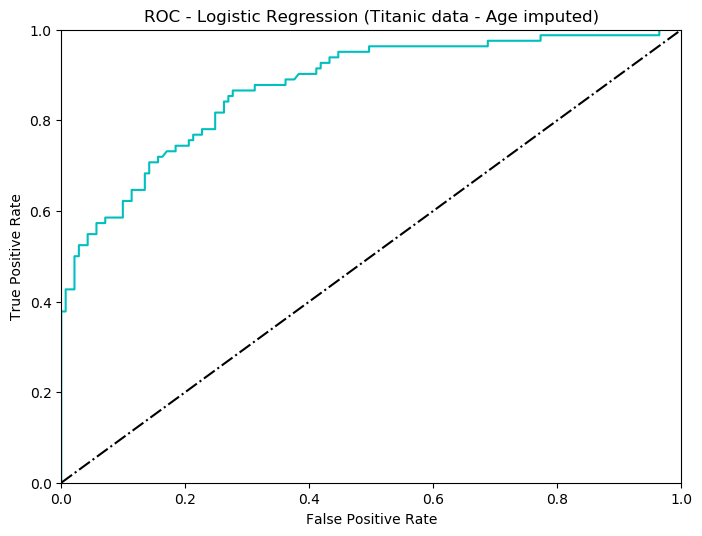

In [42]:
plt.title('ROC - Logistic Regression (Titanic data - Age imputed)')
plt.plot(fpr, tpr, 'c')
plt.plot([0, 1], [0, 1],'k-.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

In [43]:
metrics.roc_auc_score(Y_test, pred2)

0.8738107593841895

The area under the curve is 87%, which means there is an 87% chance that the second model will be able to distinguish between the two classes (survivors and deads).

## Which model is better?

Overall, the second model is slightly better at distinguishing between classes (dead vs. survived). It also uses a larger sample size (n = 891). The second model is better at predicting deaths than the first model but weaker at predicting survivors.

In this setting, choosing the right model depends on whether we care more about false positives or false negatives. Let's say we were using these models to predict survivorship before the Titanic departed. Alternatively, let's say a similar departure (with similar risk and uncertainty) was hapenning tomorrow. For example, a spaceship on Mars. In this setting, we care more about false positives - i.e. we do not want to predict someone as a survivor, tell their family the good news, and later realise that they are dead. In contrast, false negatives matter less. We would prefer to incorrectly predict someone as dead and later realise that they are alive (even if the prediction was shared with their family).

This is an ethical question. My take is that FN are preferable over FP, but this is subjective. Under this view, the second model is preferable because it is more accurate at predicting the number of deads.